In [1]:
import BioSimSpace as bss
import matplotlib.pyplot as plt
import numpy as np
import scipy
import glob
import BioSimSpace._Exceptions
import pandas as pd
import seaborn as sns
import sklearn.metrics

INFO:rdkit:Enabling RDKit 2022.09.1 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
_K_B = scipy.constants.Boltzmann
_TEMPERATURE = 300
_N_A = scipy.constants.Avogadro


def inhibition_to_ddg(ki_a: float, ki_b: float) -> float:
    """
    convert experimental Ki values to binding free-energy difference
    :param ki_a: experimental Ki of ligand 1
    :param ki_b: experimental Ki of ligand 1
    :return: experimental RBFE value
    """
    ic50_a = 2 * ki_a
    ic50_b = 2 * ki_b

    return (_K_B * _N_A * _TEMPERATURE / 4184) * np.log(ic50_b / ic50_a)


def get_experimental_error(error_a, ki_a, error_b, ki_b):
    fraction = ki_b / ki_a
    fraction_error = fraction * np.sqrt((error_b / ki_b) ** 2 + (error_a / ki_a) ** 2)
    return (_K_B * _TEMPERATURE * fraction_error / fraction) * _N_A / 4184

In [3]:
def bootstrap(experimental: np.array, calculated: np.array, n_samples = 10000, alpha_level = 0.05):
    """
    bootstrap pearson's r 
    """
    n_data_samples = len(experimental)
    statistics_dict = {"r": [],
                       "mue": [],
                       "rho": []}

    for i in range(n_samples):
        if i==0:
            experimental_samples = experimental
            calculated_samples = calculated
        else:
            bootstrap_sample = np.random.choice(range(n_data_samples), size = n_samples)
            experimental_samples = [experimental[i] for i in bootstrap_sample]
            calculated_samples = [calculated[i] for i in bootstrap_sample]
        pearson, _ = scipy.stats.pearsonr(experimental_samples, calculated_samples)
        mue = sklearn.metrics.mean_absolute_error(experimental_samples, calculated_samples)
        spearman = scipy.stats.spearmanr(experimental_samples, calculated_samples)
        statistics_dict["r"].append(pearson)
        statistics_dict["mue"].append(mue)
        statistics_dict["rho"].append(spearman)
    results = {"r": {},
               "mue": {},
               "rho": {}}
    lower_fraction = alpha_level/2.0
    upper_fraction = 1 - lower_fraction
    for statistic in statistics_dict.keys():
        results[statistic]["real"] = statistics_dict[statistic][0]
        statistics_dict[statistic] = sorted(statistics_dict[statistic])
        results[statistic]["mean"] = np.mean(statistics_dict[statistic])
        results[statistic]["lower"] = statistics_dict[statistic][int(n_samples * lower_fraction)]
        results[statistic]["upper"] = statistics_dict[statistic][int(n_samples * upper_fraction)]
    return results

In [5]:
# Add simfile header required by biosimspace/pymbar
header_file = "/home/jguven/projects/metalloenzymes/scripts/simfile_header.txt"
with open(header_file, "r") as file:
    header = file.readlines()

somd_path = "/home/jguven/projects/metalloenzymes/vim_2/outputs/"
paths = sorted(glob.glob(somd_path + "SOMD_*/*/"))
# paths = [somd_path + "lig_1~lig_4/", 
#         # somd_path + "lig_1~lig_5/"
#          ]
for path in paths:

    ligand = path.split("/")[-2]

    free_directory = path + "unbound/"
    bound_directory = path + "bound/"
    print(bound_directory)
    unbound_min_simfiles = sorted(glob.glob(free_directory + "/minimisation/lambda_*/simfile.dat"))

    unbound_simfiles = sorted(glob.glob(free_directory + "lambda_*/simfile.dat"))

    bound_simfiles = sorted(glob.glob(bound_directory + "lambda_*/simfile.dat"))

    for i in range(len(unbound_min_simfiles)):

        with open(unbound_min_simfiles[i], "r") as file:
            min_simfile_lines = file.readlines()

        with open(unbound_min_simfiles[i], "r") as file:
            for j, line in enumerate(file):
                if "lambda" in line:
                    start = j
                if "#" not in line:
                    end = j
                    break

        lambda_header = min_simfile_lines[start:end]
        full_header = header + lambda_header

        with open(unbound_simfiles[i], "r+") as file:
            data = file.readlines()
            file.seek(0, 0)
            header_and_data = full_header + data
            file.writelines(header_and_data)

        with open(bound_simfiles[i], "r+") as file:
            data = file.readlines()
            file.seek(0, 0)
            header_and_data = full_header + data
            file.writelines(header_and_data)

/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_1/lig_10~lig_6/bound/
/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_1/lig_10~lig_8/bound/
/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_1/lig_11~lig_12/bound/
/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_1/lig_11~lig_14/bound/
/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_1/lig_11~lig_3/bound/
/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_1/lig_11~lig_4/bound/
/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_1/lig_11~lig_5/bound/
/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_1/lig_12~lig_15/bound/
/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_1/lig_13~lig_16/bound/
/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_1/lig_13~lig_6/bound/
/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_1/lig_14~lig_15/bound/
/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_1/lig_15~lig_3/bound/
/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_1/l

In [6]:
# Write results in analysis files
analysis_file = "somd_results.txt"
somd_paths = sorted(glob.glob("/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_*/"))

for somd_path in somd_paths:
    output_file = somd_path + analysis_file
    paths = sorted(glob.glob(somd_path + "*/"))
    repeat = somd_path.split("/")[-2]
    print(repeat)
    with open(output_file, "w") as file:
        for path in paths:
            free_directory = path + "unbound/"
            bound_directory = path + "bound/"
            transformation = path.split("/")[-2]
            file.write(transformation + "\n")
            print(transformation)
            try:
                pmf_free, overlap_matrix_free = bss.FreeEnergy.Relative.analyse(free_directory)
                pmf_bound, overlap_matrix_bound = bss.FreeEnergy.Relative.analyse(bound_directory)    
                free_energy_difference, free_energy_error = bss.FreeEnergy.Relative.difference(pmf_bound, pmf_free)
                file.write(f"{free_energy_difference} \u00B1 {free_energy_error} \n")    
            except IndexError as e:
                print(str(e)+"\n")
            except ValueError as e:
                print(str(e)+"\n")
            except BioSimSpace._Exceptions.AnalysisError as e:
                print(str(e))


SOMD_1
lig_10~lig_6
lig_10~lig_8
lig_11~lig_12
lig_11~lig_14
lig_11~lig_3
lig_11~lig_4
lig_11~lig_5
lig_12~lig_15
lig_13~lig_16
lig_13~lig_6
lig_14~lig_15
lig_15~lig_3
lig_16~lig_9
lig_1~lig_4
lig_1~lig_5
lig_2~lig_4
lig_2~lig_9
lig_4~lig_9
lig_6~lig_7
lig_6~lig_8
lig_6~lig_9
lig_7~lig_9
SOMD_2
lig_10~lig_6
lig_10~lig_8
lig_11~lig_12
lig_11~lig_14
lig_11~lig_3
lig_11~lig_4
lig_11~lig_5
lig_12~lig_15
lig_13~lig_16
lig_13~lig_6
lig_14~lig_15
lig_15~lig_3
lig_16~lig_9
lig_1~lig_4
lig_1~lig_5
lig_2~lig_4
lig_2~lig_9
lig_4~lig_9
lig_6~lig_7
lig_6~lig_8
lig_6~lig_9
lig_7~lig_9
SOMD_3
lig_10~lig_6
lig_10~lig_8
lig_11~lig_12
lig_11~lig_14
lig_11~lig_3
lig_11~lig_4
lig_11~lig_5
lig_12~lig_15
lig_13~lig_16
lig_13~lig_6
lig_14~lig_15
lig_15~lig_3
lig_16~lig_9
lig_1~lig_4
lig_1~lig_5
lig_2~lig_4
lig_2~lig_9
lig_4~lig_9
lig_6~lig_7
lig_6~lig_8
lig_6~lig_9
lig_7~lig_9


In [4]:
# Read in results from each repeat
calculated_ddgs = []
calculated_errors = []
analysis_file = "somd_results.txt"
somd_paths = sorted(glob.glob("/home/jguven/projects/metalloenzymes/vim_2/outputs/SOMD_*/"))
for somd_path in somd_paths:
    input_file = somd_path + analysis_file
    with open(input_file, "r") as file:
        lines = file.readlines()
    results = [line for line in lines[1:len(lines):2]]
    ddgs, errors = [], []
    for result in results:
        split_results = result.split("±")
        ddgs.append(float(split_results[0].replace("kcal/mol", "").replace("⁻¹ \n", "")))
        errors.append(float(split_results[1].replace("kcal/mol", "").replace("⁻¹ \n", "").replace("kcal mol", "")))
    calculated_ddgs.append(ddgs)
    calculated_errors.append(errors)
calculated_ddgs = np.array(calculated_ddgs).T
calculated_errors = np.array(calculated_errors).T

In [5]:
# Get averages accross repeats
calculated_means = np.mean(calculated_ddgs, axis=1)
calculcated_stds = np.std(calculated_ddgs, axis=1)
print(calculated_means)
print(calculcated_stds)

[ 1.32300000e-01 -2.29585900e+02  1.52024000e+01 -2.01326667e+00
 -2.29356667e+01 -2.20050000e+00 -1.62902333e+01 -4.17333333e-02
 -1.47253333e+00  1.86066667e-01  1.14180000e+00  2.87433333e-01
  5.93326333e+01  5.06600000e-01  2.94133333e-01  2.13066667e-01
  5.76811667e+01  5.80532333e+01  1.80950000e+00 -2.29570133e+02
  5.75661667e+01  5.66061667e+01]
[ 0.15201384  0.1418436   7.06764911 19.22443178  9.70731289 14.30531572
 12.77188629  0.28222667  0.15689118  0.13241476  0.36821594  0.4530969
  0.41101911  0.27630904  0.17110639  0.03143165  0.26843111  0.13864877
  0.26017767  0.15873627  0.14701622  1.79754088]


In [6]:
filter_ids = [0, 1, 2, 3, 7, 8, 9, 10, 12, 16, 19, 20]
first_ids = [9, 9, 10, 10, 11, 12, 12, 13, 15, 1, 5, 5]
second_ids = [5, 7, 11, 13, 14, 15, 5, 14, 8, 8, 7, 8]

In [8]:
# # Get ligand indices for getting the correct experimental values
# first_indices = []
# second_indices = []
# perturbations = [line.strip() for line in lines[0:len(lines):2]]
# for line in perturbations:
#     no_newline = line.strip("\n")
#     lig_1 = no_newline.split("~")[0].replace("lig_", "")
#     lig_2 = no_newline.split("~")[1].replace("lig_", "")  
#     first_indices.append(int(lig_1) - 1)
#     second_indices.append(int(lig_2) - 1)

# for i in range(len(first_indices)):
#     print(first_indices[i], second_indices[i])

In [7]:
# Get experimental values
experimental_file = pd.read_csv("/home/jguven/projects/metalloenzymes/kpc2/afe/experimental_K_i.csv")
experimental_ki, experimental_ki_error = experimental_file["K_i"], experimental_file["K_i_err"]
# ligand_1 = experimental_ki[0]
# ligand_1_error = experimental_ki_error[0]
experimental_free_energies = []
experimental_errors = []

experimental_free_energies = []
experimental_errors = []
for i in range(len(first_ids)):
    i_1, i_2 = first_ids[i], second_ids[i]
    experimental_free_energy = inhibition_to_ddg(experimental_ki[i_1], experimental_ki[i_2])
    # error_a, ki_a, error_b, ki_b
    experimental_error = get_experimental_error(experimental_ki_error[i_1], experimental_ki[i_1], experimental_ki_error[i_2], experimental_ki[i_2])
    experimental_free_energies.append(experimental_free_energy)
    experimental_errors.append(experimental_error)
    print(i_1, i_2)

9 5
9 7
10 11
10 13
11 14
12 15
12 5
13 14
15 8
1 8
5 7
5 8


In [10]:
perturbations = [line.strip() for line in lines[0:len(lines):2]]
labels = [string.replace("lig_", "").replace("~"," to ") for string in perturbations]
# labels
clean_labels = [labels[i] for i in filter_ids]
clean_labels

['10 to 6',
 '10 to 8',
 '11 to 12',
 '11 to 14',
 '12 to 15',
 '13 to 16',
 '13 to 6',
 '14 to 15',
 '16 to 9',
 '2 to 9',
 '6 to 8',
 '6 to 9']

In [11]:
filtered_means = [calculated_means[i] for i in filter_ids]
filtered_stds = [calculcated_stds[i] for i in filter_ids]

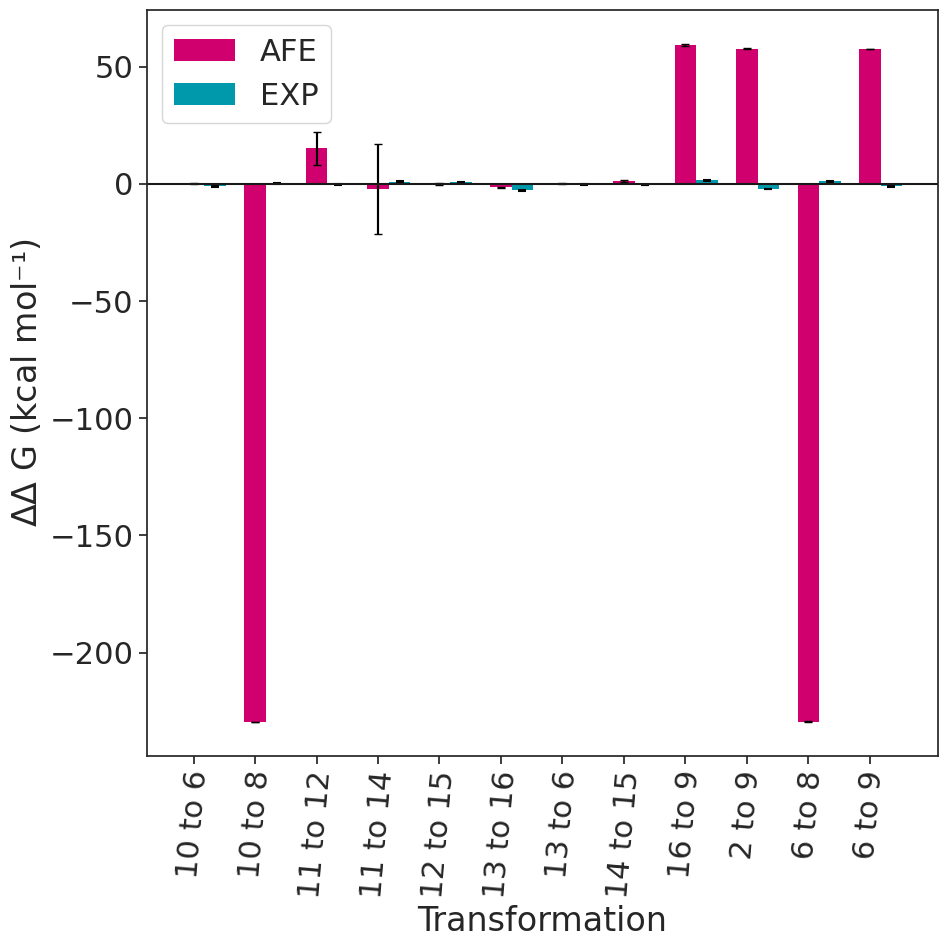

In [14]:
fig = plt.figure(figsize=(10, 10))
sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)
x_label_locations = np.arange(len(filtered_means))
bar_width = 0.35

plt.bar(x_label_locations - bar_width / 2,
        height=filtered_means,
        width=bar_width,
        yerr=filtered_stds,
        label="AFE",
        color="#D0006F",
        linewidth=0)

(_, caps, _) = plt.errorbar(x_label_locations - bar_width / 2,
                            filtered_means,
                            color="black",
                            yerr=filtered_stds,
                            capsize=3,
                            linestyle="")

plt.bar(x_label_locations + bar_width / 2,
        height=experimental_free_energies,
        width=bar_width,
        yerr=experimental_errors,
        label="EXP",
        color="#0099AB",
        linewidth=0)

(_, caps, _) = plt.errorbar(x_label_locations + bar_width / 2,
                            experimental_free_energies,
                            color="black",
                            yerr=experimental_errors,
                            capsize=3,
                            linestyle="")

for cap in caps:
    cap.set_color("black")
    cap.set_markeredgewidth(1.5)
# plt.ylim(-55, -40)
plt.axhline(0, 0, 1, c="k")
# plt.ylim(-6, 6)
plt.xticks(x_label_locations - bar_width / 2, clean_labels, rotation=85, ha="center")
plt.legend()
plt.xlabel("Transformation")
plt.ylabel("$\Delta \Delta$ G (kcal mol⁻¹)")
plt.tight_layout()
plt.savefig("ddg.png", dpi=1200, transparent=True)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│    1 plt.figure(figsize=(10, 10))                                                                │
│    2 sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)              │
│ ❱  3 plt.scatter(experimental_free_energies, calculated_means, s=50, color="#D0006F")            │
│    4 # plt.scatter(3, 2.5, s=0)                                                                  │
│    5                                                                                             │
│    6 (_, caps, _) = plt.errorbar(experimental_free_energies,                                     │
│                                                                                                  │
│ /home/jguven/Software/miniconda3/envs/bss-d/lib/python3.9/site-packages/matplotlib/pyplot.py:279 │
│ 8 in scatter                                                                                     │
│                                                                                                  │
│   2795 │   │   x, y, s=None, c=None, marker=None, cmap=None, norm=None,                          │
│   2796 │   │   vmin=None, vmax=None, alpha=None, linewidths=None, *,                             │
│   2797 │   │   edgecolors=None, plotnonfinite=False, data=None, **kwargs):                       │
│ ❱ 2798 │   __ret = gca().scatter(                                                                │
│   2799 │   │   x, y, s=s, c=c, marker=marker, cmap=cmap, norm=norm,                              │
│   2800 │   │   vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths,                         │
│   2801 │   │   edgecolors=edgecolors, plotnonfinite=plotnonfinite,                               │
│                                                                                                  │
│ /home/jguven/Software/miniconda3/envs/bss-d/lib/python3.9/site-packages/matplotlib/__init__.py:1 │
│ 433 in inner                                                                                     │
│                                                                                                  │
│   1430 │   @functools.wraps(func)                                                                │
│   1431 │   def inner(ax, *args, data=None, **kwargs):                                            │
│   1432 │   │   if data is None:                                                                  │
│ ❱ 1433 │   │   │   return func(ax, *map(sanitize_sequence, args), **kwargs)                      │
│   1434 │   │                                                                                     │
│   1435 │   │   bound = new_sig.bind(ax, *args, **kwargs)                                         │
│   1436 │   │   auto_label = (bound.arguments.get(label_namer)                                    │
│                                                                                                  │
│ /home/jguven/Software/miniconda3/envs/bss-d/lib/python3.9/site-packages/matplotlib/axes/_axes.py │
│ :4526 in scatter                                                                                 │
│                                                                                                  │
│   4523 │   │   x = np.ma.ravel(x)                                                                │
│   4524 │   │   y = np.ma.ravel(y)                                                                │
│   4525 │   │   if x.size != y.size:                                                              │
│ ❱ 4526 │   │   │   raise ValueError("x and y must be the same size")                             │
│   4527 │   │                                               

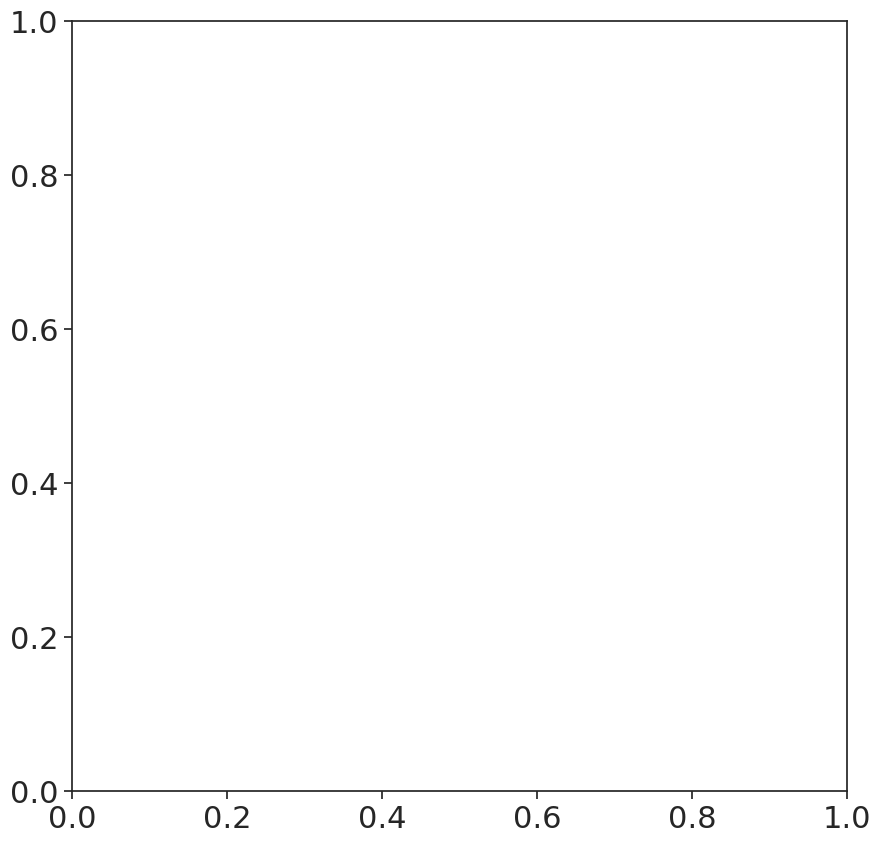

In [15]:
plt.figure(figsize=(10, 10))
sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)
plt.scatter(experimental_free_energies, calculated_means, s=50, color="#D0006F")
# plt.scatter(3, 2.5, s=0)

(_, caps, _) = plt.errorbar(experimental_free_energies,
                           calculated_means,
                           color="#D0006F",
                           yerr=calculcated_stds,
                           capsize=3,
                           linestyle="",
                           zorder=-1)

plt.plot([-4.5, 4.5], [-4.5, 4.5], color="#0099AB", linestyle=":", zorder=-1)
plt.xlabel("$\Delta \Delta$ G$_\mathrm{EXP}$ (kcal mol⁻¹)")
plt.ylabel("$\Delta \Delta$ G$_\mathrm{AFE}$ (kcal mol⁻¹)")
plt.vlines(0, -3.5, 3.5, color = "silver", linestyle="--", zorder=-1)
plt.hlines(0, -3.5, 3.5, color = "silver", linestyle="--", zorder=-1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.tight_layout()
for i in range(len(labels)):
    plt.annotate(labels[i], (experimental_free_energies[i], calculated_means[i]))
# plt.savefig("corr.png", dpi=1200, transparent=True)
plt.show()

In [13]:
pearson_r = scipy.stats.pearsonr(experimental_free_energies, calculated_means)
pearson_r

PearsonRResult(statistic=0.8361613217258689, pvalue=1.2555500864017351e-06)

In [14]:
spearman = scipy.stats.spearmanr(experimental_free_energies, calculated_means)
spearman

SignificanceResult(statistic=0.8531902879728968, pvalue=4.5142615003636913e-07)

In [15]:
mue = sklearn.metrics.mean_absolute_error(experimental_free_energies, calculated_means)
mue

0.5633331683181537

In [16]:
stats = bootstrap(experimental_free_energies, calculated_means)
stats

{'r': {'real': 0.8361613217258689,
  'mean': 0.8361592859641869,
  'lower': 0.8308644164103376,
  'upper': 0.8412456483522717},
 'mue': {'real': 0.5633331683181537,
  'mean': 0.5633005545596538,
  'lower': 0.5530645181526705,
  'upper': 0.5736524466461721},
 'rho': {'real': SignificanceResult(statistic=0.8531902879728968, pvalue=4.5142615003636913e-07),
  'mean': 0.4265763614970577,
  'lower': SignificanceResult(statistic=0.8464805464737262, pvalue=0.0),
  'upper': SignificanceResult(statistic=0.8594809202549037, pvalue=0.0)}}

In [29]:
calculated_ddgs[:, 0]

array([-0.1204,  0.0154, -0.4448,  0.7528, -1.1246, -0.6325, -0.5446,
       -0.5147, -1.7624, -0.6154, -1.4862, -0.5119,  0.5061, -0.1422,
        0.7615,  0.9814,  0.044 , -2.3399,  0.3236,  1.0306, -1.0163,
        0.2017])

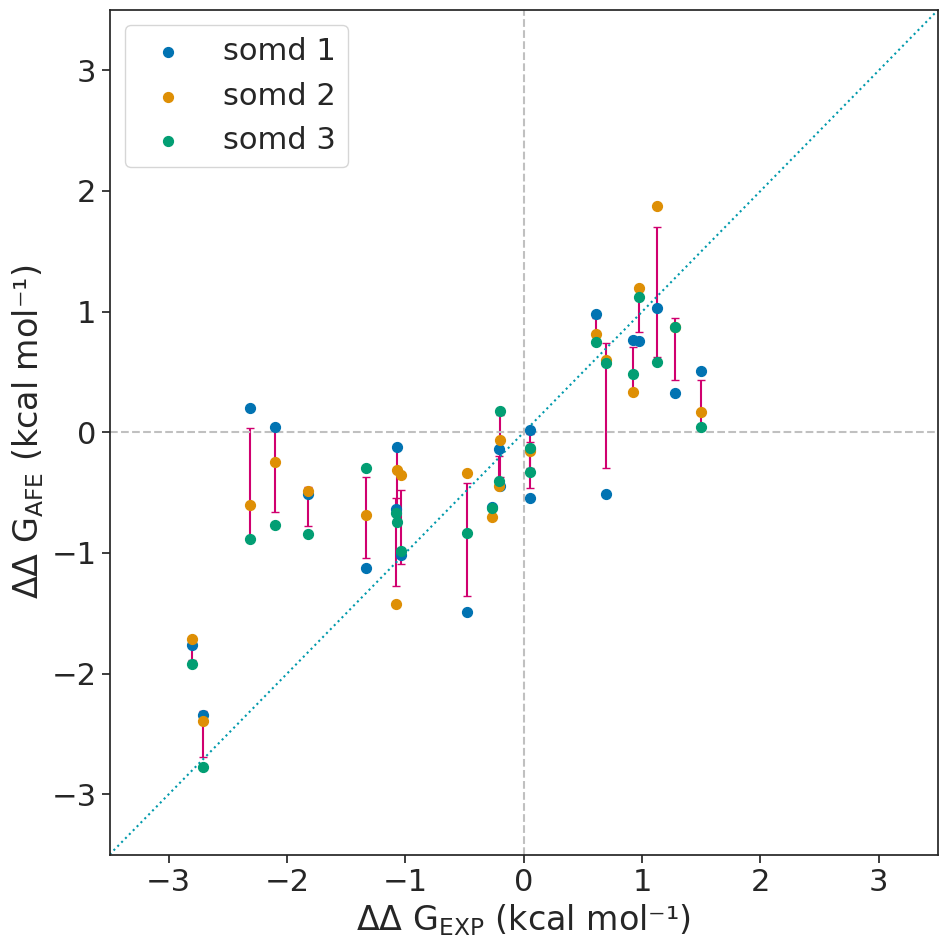

In [30]:
plt.figure(figsize=(10, 10))
sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)
plt.scatter(experimental_free_energies, calculated_ddgs[:,0], s=50, label="somd 1")
plt.scatter(experimental_free_energies, calculated_ddgs[:,1], s=50, label="somd 2")
plt.scatter(experimental_free_energies, calculated_ddgs[:,2], s=50, label="somd 3")
# plt.scatter(3, 2.5, s=0)

(_, caps, _) = plt.errorbar(experimental_free_energies,
                           calculated_means,
                           color="#D0006F",
                           yerr=calculcated_stds,
                           capsize=3,
                           linestyle="",
                           zorder=-1)

plt.plot([-4.5, 4.5], [-4.5, 4.5], color="#0099AB", linestyle=":", zorder=-1)
plt.xlabel("$\Delta \Delta$ G$_\mathrm{EXP}$ (kcal mol⁻¹)")
plt.ylabel("$\Delta \Delta$ G$_\mathrm{AFE}$ (kcal mol⁻¹)")
plt.vlines(0, -3.5, 3.5, color = "silver", linestyle="--", zorder=-1)
plt.hlines(0, -3.5, 3.5, color = "silver", linestyle="--", zorder=-1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.tight_layout()
# for i in range(len(labels)):
    # plt.annotate(labels[i], (experimental_free_energies[i], calculated_means[i]))
# plt.savefig("corr.png", dpi=1200, transparent=True)
plt.legend()
plt.show()